In [1]:
from __future__ import annotations
from typing import Any
import sys, os
from pathlib import Path
import re
import json

import matplotlib.pyplot as plt

from tactic_gen.parse_log import parse_train_longs, parse_eval_logs, TrainLog, EvalLog

In [2]:
if Path(os.curdir).resolve().name == "tactic_gen":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling": 
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")

In [3]:
MODELS_DIR_PATH = Path("models")

In [4]:
MODEL_NAMES = [
    #"select-proj-final",
    #"select-proj-random",
    # "select-all-random",

    # Random
    # "deepseek-basic-random",
    # "deepseek-prem-random",
    # "deepseek-proof-random",
    # "deepseek-prefix-random",
    # "deepseek-proof-prem-random",

    # Official
    #"deepseek-basic-final",
    # "tf-idf-proof-only-final",
    # "deepseek-proof-final",
    "deepseek-bm-25-proof-ret-final",
    "bm25-proof-bm25-proj-prem-final",
    "bm25-proj-prem-final",
    "select-proj-prem-final",

    #"tf-idf-proof-only-final",
    #"deepseek-bm-25-premises-theorem-only-final"

    # "deepseek-prem-final",
    # "deepseek-codebert-raw-proof-final",
    # "deepseek-bm-25-proof-ret-final",
    # "deepseek-prefix-final",
    # "deepseek-proof-prem-final",
]

In [5]:
def get_latest_train_state(models_dir, model_name):
    model_path = os.path.join(models_dir, model_name)
    max_checkpoint_num = -1 
    for checkpoint_name in os.listdir(model_path):
        checkpoint_match = re.match(r"checkpoint-(\d+)", checkpoint_name) 
        if checkpoint_match is None:
            continue
        checkpoint_num_str, = checkpoint_match.groups()
        checkpoint_num = int(checkpoint_num_str)
        if checkpoint_num > max_checkpoint_num:
            max_checkpoint_num = checkpoint_num
    assert max_checkpoint_num > 0 
    checkpoint_name = f"checkpoint-{max_checkpoint_num}"
    train_state_loc = os.path.join(models_dir, model_name, checkpoint_name, "trainer_state.json")
    with open(train_state_loc, "r") as fin:
        return json.load(fin)

In [6]:
def plot_loss(train_logs: list[TrainLog], 
              eval_logs: list[EvalLog],
              label: str,
              ax: plt.axes.Axes) -> None:
    train_xs = [s.step for s in train_logs]
    train_ys = [s.loss for s in train_logs]
    eval_xs = [s.step for s in eval_logs]
    eval_ys = [s.eval_loss for s in eval_logs]
    #ax.set_ylim(0, 1.5)
    #ax.set_ylim(0, 0.1)
    #ax.plot(train_xs, train_ys, label=f"{label} Training Loss")
    ax.plot(eval_xs, eval_ys, label=f"{label} Validation Loss")
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    ax.set_title(f"Loss")
    ax.legend()

deepseek-bm-25-proof-ret-final
train loss 0.3771
evalloss 0.7974787950515747
bm25-proof-bm25-proj-prem-final
train loss 0.3795
evalloss 0.8188908696174622
bm25-proj-prem-final
train loss 0.4112
evalloss 1.0426100492477417
select-proj-prem-final
train loss 0.4808
evalloss 1.094821572303772


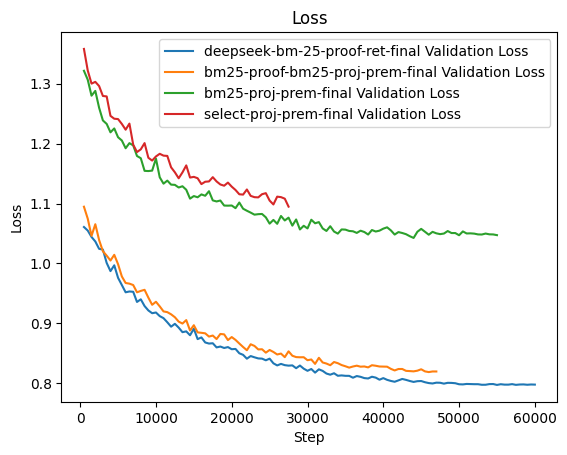

In [7]:
fig, ax = plt.subplots()
for m in MODEL_NAMES:
    print(m)
    train_state_data = get_latest_train_state(MODELS_DIR_PATH, m)
    train_logs = parse_train_longs(train_state_data["log_history"])
    eval_logs = parse_eval_logs(train_state_data["log_history"])
    print("train loss", min([l.loss for l in train_logs]))
    print("evalloss", min([l.eval_loss for l in eval_logs]))
    plot_loss(train_logs, eval_logs, m, ax)